#Pemrograman Tugas Akhir:


"Segmentasi Burned Area menggunakan Model U-Net pada Citra Landsat 9 (Studi Kasus: Sumatera Selatan)"

*   Clip Raster
*   Band Stacking
*   Image Patching





# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 46.4 MB/s eta 0:00:00


# Cek Ukuran Citra

In [ ]:
import rasterio

# Daftar path
raster_paths = [
  '/content/drive/MyDrive/GEE_Export/FalseColor_124062.tif',
  '/content/drive/MyDrive/GEE_Export/FalseColor_125062.tif',
  '/content/drive/MyDrive/GEE_Export/NBR_124062.tif',
  '/content/drive/MyDrive/GEE_Export/NBR_125062.tif',
  '/content/drive/MyDrive/GEE_Export/NDVI_124062.tif',
  '/content/drive/MyDrive/GEE_Export/NDVI_125062.tif',
  '/content/drive/MyDrive/GEE_Export/MASK_124062.tif',
  '/content/drive/MyDrive/GEE_Export/MASK_125062.tif'
]

# Loop untuk menampilkan info setiap citra
for path in raster_paths:
    with rasterio.open(path) as src:
        width = src.width
        height = src.height
        crs = src.crs
        bounds = src.bounds

        print(f"\n--- Informasi Raster: {path.split('/')[-1]} ---")
        print(f"Ukuran raster       : {width} x {height} piksel")
        print(f"CRS                 : {crs}")
        print(f"Batas koordinat     : {bounds}")



--- Informasi Raster: FalseColor_124062.tif ---
Ukuran raster       : 7587 x 7772 piksel
CRS                 : EPSG:4326
Batas koordinat     : BoundingBox(left=103.72415394391739, bottom=-3.9432447711710514, right=105.76880936210183, top=-1.8487328547179753)

--- Informasi Raster: FalseColor_125062.tif ---
Ukuran raster       : 7584 x 7774 piksel
CRS                 : EPSG:4326
Batas koordinat     : BoundingBox(left=102.18857379724348, bottom=-3.9435142657562876, right=104.23242073167222, top=-1.8484633601327396)

--- Informasi Raster: NBR_124062.tif ---
Ukuran raster       : 7587 x 7772 piksel
CRS                 : EPSG:4326
Batas koordinat     : BoundingBox(left=103.72415394391739, bottom=-3.9432447711710514, right=105.76880936210183, top=-1.8487328547179753)

--- Informasi Raster: NBR_125062.tif ---
Ukuran raster       : 7584 x 7774 piksel
CRS                 : EPSG:4326
Batas koordinat     : BoundingBox(left=102.18857379724348, bottom=-3.9435142657562876, right=104.23242073167222,

Karena Citra yang didownload dari GEE belum pas sesuai filterr eq pathrow, berlebih dari batas pathrow WRS, karena dapat mempengaruhi proses Band stacking dan Iamge patching karena ukuran semua citra tidak sama, maka dilakukan CLIP masing-masing citra raster dengan SHP WRS Pathrow Landsat dari https://www.usgs.gov/media/files/landsat-wrs-2-descending-path-row-shapefile dengan proyeksi yang sama dengan citra raster yaitu WGS 84, agar semua memiliki ukuran sama dan tidak berbeda 1 piksel pun

# Clip Raster

In [ ]:
# Jalankan ini sekali di Colab untuk install GDAL
!apt install -y gdal-bin python3-gdal

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  libgdal-grass python-numpy-doc python3-pytest
The following NEW packages will be installed:
  gdal-bin python3-gdal python3-numpy
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 5,168 kB of archives.
After this operation, 25.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3-numpy amd64 1:1.21.5-1ubuntu22.04.1 [3,467 kB]
Get:2 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 python3-gdal amd64 3.8.4+dfsg-1~jammy0 [1,095 kB]
Get:3 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 gdal-bin amd64 3.8.4+dfsg-1~jammy0 [605 kB]
Fetched 5,168 kB in 3s (1,641 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 126284 files and directories curren

In [ ]:
import subprocess
import os

# Daftar path raster yang ingin dipotong
raster_paths = [
  '/content/drive/MyDrive/GEE_Export/FalseColor_124062.tif',
  '/content/drive/MyDrive/GEE_Export/FalseColor_125062.tif',
  '/content/drive/MyDrive/GEE_Export/NBR_124062.tif',
  '/content/drive/MyDrive/GEE_Export/NBR_125062.tif',
  '/content/drive/MyDrive/GEE_Export/NDVI_124062.tif',
  '/content/drive/MyDrive/GEE_Export/NDVI_125062.tif',
  '/content/drive/MyDrive/GEE_Export/MASK_124062.tif',
  '/content/drive/MyDrive/GEE_Export/MASK_125062.tif'
]

# Shapefile untuk masing-masing kelompok
shapefiles = {
    '124': '/content/drive/MyDrive/Data Riset/WRS LANDSAT PATHROW/WRS124.shp',
    '125': '/content/drive/MyDrive/Data Riset/WRS LANDSAT PATHROW/WRS125.shp'
}

# Folder output
output_folder = '/content/drive/MyDrive/Data Riset/Data before split'
os.makedirs(output_folder, exist_ok=True)

# Loop untuk clip setiap raster
for raster_path in raster_paths:
    filename = os.path.basename(raster_path)

    # Deteksi apakah ini citra untuk pathrow 124 atau 125
    if '124' in filename:
        shapefile = shapefiles['124']
    elif '125' in filename:
        shapefile = shapefiles['125']
    else:
        print(f"Tidak ditemukan pathrow yang sesuai dalam nama file: {filename}")
        continue

    output_path = os.path.join(output_folder, f'CLIP_{filename}')

    # Jalankan proses gdalwarp
    subprocess.run([
        'gdalwarp',
        '-cutline', shapefile,
        '-crop_to_cutline',
        '-of', 'GTiff',
        raster_path,
        output_path
    ])

    print(f'Clip selesai: {output_path}')


Clip selesai: /content/drive/MyDrive/Data Riset/Data before split/CLIP_FalseColor_124062.tif
Clip selesai: /content/drive/MyDrive/Data Riset/Data before split/CLIP_FalseColor_125062.tif
Clip selesai: /content/drive/MyDrive/Data Riset/Data before split/CLIP_NBR_124062.tif
Clip selesai: /content/drive/MyDrive/Data Riset/Data before split/CLIP_NBR_125062.tif
Clip selesai: /content/drive/MyDrive/Data Riset/Data before split/CLIP_NDVI_124062.tif
Clip selesai: /content/drive/MyDrive/Data Riset/Data before split/CLIP_NDVI_125062.tif
Clip selesai: /content/drive/MyDrive/Data Riset/Data before split/CLIP_MASK_124062.tif
Clip selesai: /content/drive/MyDrive/Data Riset/Data before split/CLIP_MASK_125062.tif


In [ ]:
# CEK KEMBALI UKURAN CITRA
import rasterio

# Daftar path ke 6 citra raster
raster_paths = [
    '/content/drive/MyDrive/Data Riset/Data before split/CLIP_FalseColor_124062.tif',
    '/content/drive/MyDrive/Data Riset/Data before split/CLIP_FalseColor_125062.tif',
    '/content/drive/MyDrive/Data Riset/Data before split/CLIP_NBR_124062.tif',
    '/content/drive/MyDrive/Data Riset/Data before split/CLIP_NBR_125062.tif',
    '/content/drive/MyDrive/Data Riset/Data before split/CLIP_NDVI_124062.tif',
    '/content/drive/MyDrive/Data Riset/Data before split/CLIP_NDVI_125062.tif',
    '/content/drive/MyDrive/Data Riset/Data before split/CLIP_MASK_125062.tif',
    '/content/drive/MyDrive/Data Riset/Data before split/CLIP_MASK_124062.tif'
]

# Loop untuk menampilkan info setiap citra
for path in raster_paths:
    with rasterio.open(path) as src:
        width = src.width
        height = src.height
        crs = src.crs
        bounds = src.bounds

        print(f"\n--- Informasi Raster: {path.split('/')[-1]} ---")
        print(f"Ukuran raster       : {width} x {height} piksel")
        print(f"CRS                 : {crs}")
        print(f"Batas koordinat     : {bounds}")



--- Informasi Raster: CLIP_FalseColor_124062.tif ---
Ukuran raster       : 7313 x 6533 piksel
CRS                 : EPSG:4326
Batas koordinat     : BoundingBox(left=103.75703228331616, bottom=-3.7734631824724625, right=105.72784618514598, top=-2.012855057126612)

--- Informasi Raster: CLIP_FalseColor_125062.tif ---
Ukuran raster       : 7313 x 6533 piksel
CRS                 : EPSG:4326
Batas koordinat     : BoundingBox(left=102.212019826159, bottom=-3.7734631824724625, right=104.18283372798882, top=-2.012855057126612)

--- Informasi Raster: CLIP_NBR_124062.tif ---
Ukuran raster       : 7313 x 6533 piksel
CRS                 : EPSG:4326
Batas koordinat     : BoundingBox(left=103.75703228331616, bottom=-3.7734631824724625, right=105.72784618514598, top=-2.012855057126612)

--- Informasi Raster: CLIP_NBR_125062.tif ---
Ukuran raster       : 7313 x 6533 piksel
CRS                 : EPSG:4326
Batas koordinat     : BoundingBox(left=102.212019826159, bottom=-3.7734631824724625, right=104.18

# Band stacking

## Multiband Pathrow 124

In [ ]:
from osgeo import gdal
import numpy as np
from google.colab import drive

# === 1. Mount Google Drive ===
drive.mount('/content/drive')

# === 2. Path input ===
ndvi_path = '/content/drive/MyDrive/Data Riset/Data before split/CLIP_NDVI_124062.tif'
nbr_path = '/content/drive/MyDrive/Data Riset/Data before split/CLIP_NBR_124062.tif'
false_color_path = '/content/drive/MyDrive/Data Riset/Data before split/CLIP_FalseColor_124062.tif'

# === 3. Baca masing-masing file ===
ndvi_ds = gdal.Open(ndvi_path)
nbr_ds = gdal.Open(nbr_path)
false_color_ds = gdal.Open(false_color_path)

ndvi_band = ndvi_ds.GetRasterBand(1).ReadAsArray()
nbr_band = nbr_ds.GetRasterBand(1).ReadAsArray()
fc_band1 = false_color_ds.GetRasterBand(3).ReadAsArray()  #b4
fc_band2 = false_color_ds.GetRasterBand(2).ReadAsArray()  #b5
fc_band3 = false_color_ds.GetRasterBand(1).ReadAsArray()  #b7

# === 4. Stack menjadi 5 band: NDVI, NBR, NIR, Red, Green ===
stacked_array = np.stack([ndvi_band, nbr_band, fc_band1, fc_band2, fc_band3], axis=0)

# === 5. Output ke Drive ===
output_path = '/content/drive/MyDrive/Data Riset/Data before split/MULTIBAND124.tif'
driver = gdal.GetDriverByName('GTiff')
rows, cols = ndvi_band.shape
out_ds = driver.Create(output_path, cols, rows, 5, gdal.GDT_Float32)

# Set georeferensi dari NDVI (asumsi semuanya align)
out_ds.SetGeoTransform(ndvi_ds.GetGeoTransform())
out_ds.SetProjection(ndvi_ds.GetProjection())

# Simpan masing-masing band
for i in range(5):
    out_ds.GetRasterBand(i+1).WriteArray(stacked_array[i])

#out_ds.FlushCache()
del out_ds

print("Band stacking sukses. File disimpan di:", output_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Band stacking sukses. File disimpan di: /content/drive/MyDrive/Data Riset/Data before split/MULTIBAND124.tif


## Multiband Pathrow 125

In [ ]:
from osgeo import gdal
import numpy as np
from google.colab import drive

# === 1. Mount Google Drive ===
drive.mount('/content/drive')

# === 2. Path input ===
ndvi_path = '/content/drive/MyDrive/Data Riset/Data before split/CLIP_NDVI_125062.tif'
nbr_path = '/content/drive/MyDrive/Data Riset/Data before split/CLIP_NBR_125062.tif'
false_color_path = '/content/drive/MyDrive/Data Riset/Data before split/CLIP_FalseColor_125062.tif'

# === 3. Baca masing-masing file ===
ndvi_ds = gdal.Open(ndvi_path)
nbr_ds = gdal.Open(nbr_path)
false_color_ds = gdal.Open(false_color_path)

ndvi_band = ndvi_ds.GetRasterBand(1).ReadAsArray()
nbr_band = nbr_ds.GetRasterBand(1).ReadAsArray()
fc_band1 = false_color_ds.GetRasterBand(3).ReadAsArray()  #b4
fc_band2 = false_color_ds.GetRasterBand(2).ReadAsArray()  #b5
fc_band3 = false_color_ds.GetRasterBand(1).ReadAsArray()  #b7

# === 4. Stack menjadi 5 band: NDVI, NBR, NIR, Red, Green ===
stacked_array = np.stack([ndvi_band, nbr_band, fc_band1, fc_band2, fc_band3], axis=0)

# === 5. Output ke Drive ===
output_path = '/content/drive/MyDrive/Data Riset/Data before split/MULTIBAND125.tif'
driver = gdal.GetDriverByName('GTiff')
rows, cols = ndvi_band.shape
out_ds = driver.Create(output_path, cols, rows, 5, gdal.GDT_Float32)

# Set georeferensi dari NDVI (asumsi semuanya align)
out_ds.SetGeoTransform(ndvi_ds.GetGeoTransform())
out_ds.SetProjection(ndvi_ds.GetProjection())

# Simpan masing-masing band
for i in range(5):
    out_ds.GetRasterBand(i+1).WriteArray(stacked_array[i])

#out_ds.FlushCache()
del out_ds

print("Band stacking sukses. File disimpan di:", output_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Band stacking sukses. File disimpan di: /content/drive/MyDrive/Data Riset/Data before split/MULTIBAND125.tif


# Image Patching

In [ ]:
!pip install patchify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 58.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


## Overlap 50%

In [ ]:
import os
import numpy as np
import rasterio
from patchify import patchify

# --- Input path dan output folder ---
inputs = {
    'falsecolor': {
        'path': '/content/drive/MyDrive/Data Riset/Data before split/CLIP_FalseColor_124062.tif',
        'output': '/content/drive/MyDrive/Data Riset/Data Patch/124/FALSECOLOR/',
        'suffix': '_124_falsecolor'
    },
    'mask': {
        'path': '/content/drive/MyDrive/Data Riset/Data before split/CLIP_MASK_124062.tif',
        'output': '/content/drive/MyDrive/Data Riset/Data Patch/124/MASK',
        'suffix': '_124_mask'
    },
    'multiband': {
        'path': '/content/drive/MyDrive/Data Riset/Data before split/MULTIBAND124.tif',
        'output': '/content/drive/MyDrive/Data Riset/Data Patch/124/MULTIBAND/',
        'suffix': '_124_multiband'
    }
}

# --- Buat folder output jika belum ada ---
for info in inputs.values():
    os.makedirs(info['output'], exist_ok=True)

# --- Fungsi patching dan simpan dengan overlap 50% ---
def patch_and_save(img_path, out_dir, suffix, patch_size=512, overlap=0.5):
    with rasterio.open(img_path) as src:
        img = src.read()
        meta = src.meta
        h, w = img.shape[1], img.shape[2]
        c = img.shape[0]
        res = src.res
        bounds = src.bounds
        transform = src.transform

    # Transpose ke (H, W, C)
    img = np.transpose(img, (1, 2, 0))

    # Hitung langkah patching (step)
    step = int(patch_size * (1 - overlap))

    # Patchify
    patches = patchify(img, (patch_size, patch_size, img.shape[2]), step=step)

    patch_count = 0
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            single_patch = patches[i, j, 0]
            patch = np.transpose(single_patch, (2, 0, 1))  # (C, H, W)

            # Update metadata
            patch_meta = meta.copy()
            patch_meta.update({
                "height": patch_size,
                "width": patch_size,
                "transform": rasterio.transform.from_origin(
                    bounds.left + j * step * res[0],
                    bounds.top - i * step * res[1],
                    res[0], res[1]
                )
            })

            # Simpan patch
            patch_name = f"patch_{patch_count:04d}{suffix}.tif"
            patch_path = os.path.join(out_dir, patch_name)

            with rasterio.open(patch_path, 'w', **patch_meta) as dst:
                dst.write(patch)

            patch_count += 1

    return patch_count

# --- Jalankan patching semua input ---
total = None
for key, info in inputs.items():
    print(f" Memproses: {key}")
    count = patch_and_save(info['path'], info['output'], info['suffix'], patch_size=512, overlap=0.5)
    print(f" Total patch tersimpan untuk {key}: {count}")
    if total is None:
        total = count
    elif total != count:
        print(f" Warning: Jumlah patch tidak konsisten antara citra!")

print(f"\ Proses selesai. Total patch per jenis: {total}")


In [ ]:
import os
import numpy as np
import rasterio
from patchify import patchify

# --- Input path dan output folder ---
inputs = {
    'falsecolor': {
        'path': '/content/drive/MyDrive/Data Riset/Data before split/CLIP_FalseColor_125062.tif',
        'output': '/content/drive/MyDrive/Data Riset/Data Patch/125/FALSECOLOR/',
        'suffix': '_125_falsecolor'
    },
    'mask': {
        'path': '/content/drive/MyDrive/Data Riset/Data before split/CLIP_MASK_125062.tif',
        'output': '/content/drive/MyDrive/Data Riset/Data Patch/125/MASK',
        'suffix': '_125_mask'
    },
    'multiband': {
        'path': '/content/drive/MyDrive/Data Riset/Data before split/MULTIBAND125.tif',
        'output': '/content/drive/MyDrive/Data Riset/Data Patch/125/MULTIBAND/',
        'suffix': '_125_multiband'
    }
}

# --- Buat folder output jika belum ada ---
for info in inputs.values():
    os.makedirs(info['output'], exist_ok=True)

# --- Fungsi patching dan simpan dengan overlap 50% ---
def patch_and_save(img_path, out_dir, suffix, patch_size=512, overlap=0.5):
    with rasterio.open(img_path) as src:
        img = src.read()
        meta = src.meta
        h, w = img.shape[1], img.shape[2]
        c = img.shape[0]
        res = src.res
        bounds = src.bounds
        transform = src.transform

    # Transpose ke (H, W, C)
    img = np.transpose(img, (1, 2, 0))

    # Hitung langkah patching (step)
    step = int(patch_size * (1 - overlap))

    # Patchify
    patches = patchify(img, (patch_size, patch_size, img.shape[2]), step=step)

    patch_count = 0
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            single_patch = patches[i, j, 0]
            patch = np.transpose(single_patch, (2, 0, 1))  # (C, H, W)

            # Update metadata
            patch_meta = meta.copy()
            patch_meta.update({
                "height": patch_size,
                "width": patch_size,
                "transform": rasterio.transform.from_origin(
                    bounds.left + j * step * res[0],
                    bounds.top - i * step * res[1],
                    res[0], res[1]
                )
            })

            # Simpan patch
            patch_name = f"patch_{patch_count:04d}{suffix}.tif"
            patch_path = os.path.join(out_dir, patch_name)

            with rasterio.open(patch_path, 'w', **patch_meta) as dst:
                dst.write(patch)

            patch_count += 1

    return patch_count

# --- Jalankan patching semua input ---
total = None
for key, info in inputs.items():
    print(f" Memproses: {key}")
    count = patch_and_save(info['path'], info['output'], info['suffix'], patch_size=512, overlap=0.5)
    print(f" Total patch tersimpan untuk {key}: {count}")
    if total is None:
        total = count
    elif total != count:
        print(f" Warning: Jumlah patch tidak konsisten antara citra!")

print(f"\ Proses selesai. Total patch per jenis: {total}")


# Statistik Jumlah data Image Patching

Folder                                             | Jumlah File  | Grup
--------------------------------------------------------------------------------
/content/drive/MyDrive/Data Riset/Data Patch/124/FALSECOLOR/ | 648          | Overlap
/content/drive/MyDrive/Data Riset/Data Patch/125/FALSECOLOR/ | 648          | Overlap
/content/drive/MyDrive/Data Riset/Data Patch/124/MULTIBAND/ | 648          | Overlap
/content/drive/MyDrive/Data Riset/Data Patch/125/MULTIBAND/ | 648          | Overlap
/content/drive/MyDrive/Data Riset/Data Patch/124/MASK/ | 648          | Overlap
/content/drive/MyDrive/Data Riset/Data Patch/125/MASK/ | 648          | Overlap


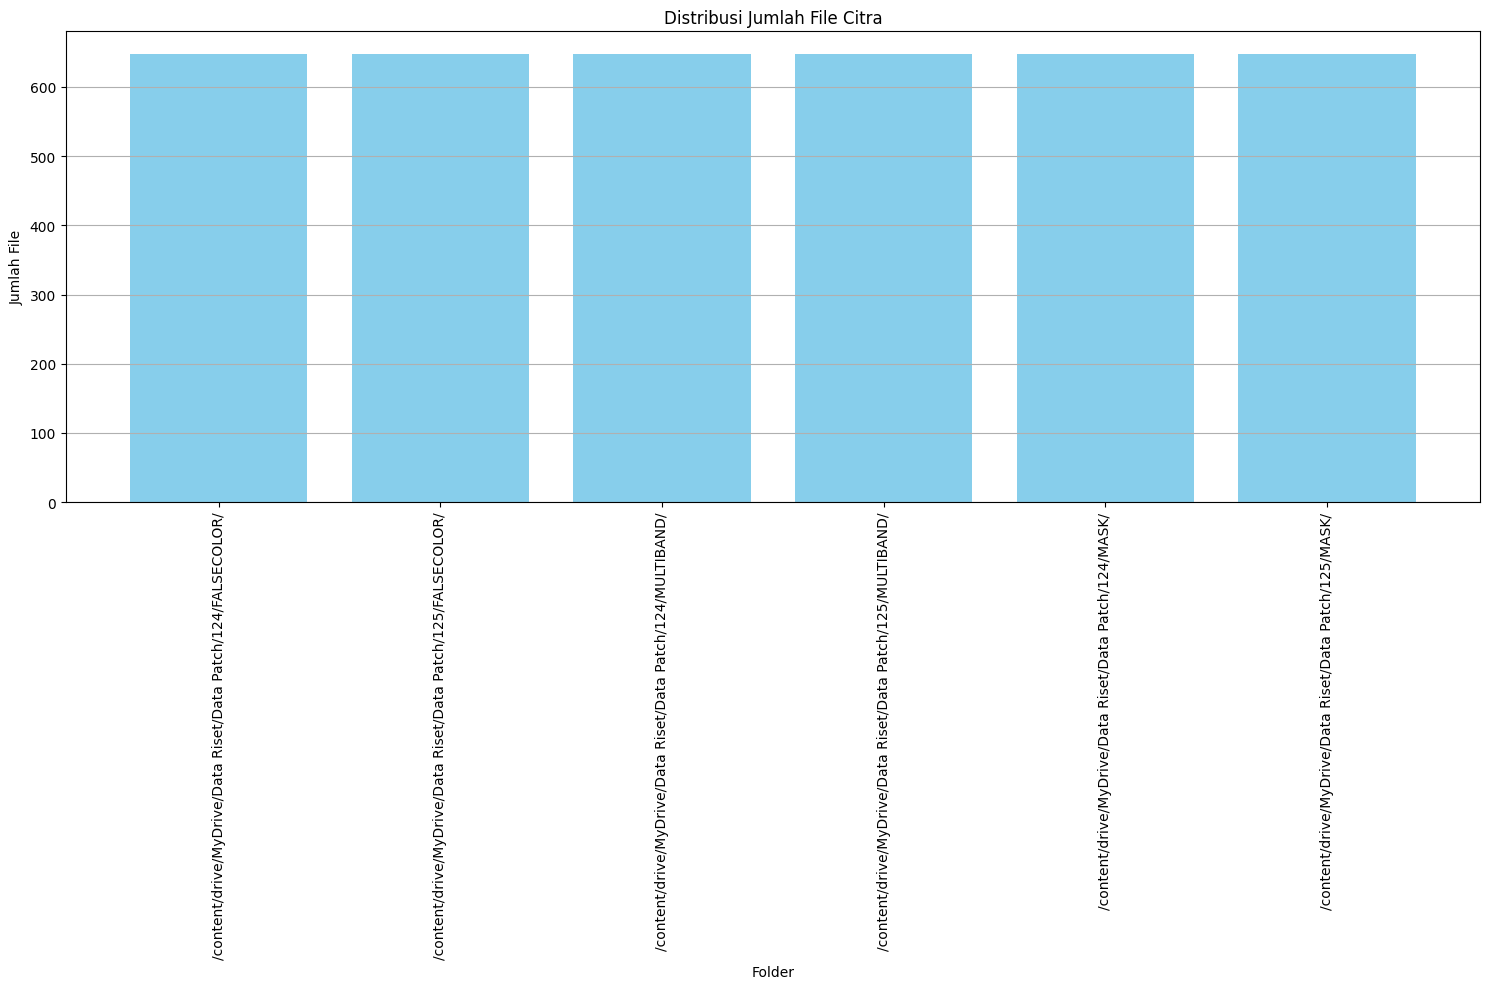

In [27]:
import glob
import matplotlib.pyplot as plt

# Struktur folder
overlap_paths = [
  '/content/drive/MyDrive/Data Riset/Data Patch/124/FALSECOLOR/',
  '/content/drive/MyDrive/Data Riset/Data Patch/125/FALSECOLOR/',
  '/content/drive/MyDrive/Data Riset/Data Patch/124/MULTIBAND/',
  '/content/drive/MyDrive/Data Riset/Data Patch/125/MULTIBAND/',
  '/content/drive/MyDrive/Data Riset/Data Patch/124/MASK/',
  '/content/drive/MyDrive/Data Riset/Data Patch/125/MASK/'

]


# Fungsi hitung file
def hitung_file(path):
    return len(glob.glob(path + '/*'))

# Simpan hasil
folder_labels = []
jumlah_file = []
grup_warna = []

for path in overlap_paths:
    label = path.split("DATA BURNED AREA/")[-1]
    folder_labels.append(label)
    jumlah_file.append(hitung_file(path))
    grup_warna.append('Overlap')


# Tampilkan hasil
print(f"{'Folder':50} | {'Jumlah File':12} | Grup")
print("-" * 80)
for label, jumlah, grup in zip(folder_labels, jumlah_file, grup_warna):
    print(f"{label:50} | {jumlah:<12} | {grup}")

# Visualisasi
plt.figure(figsize=(15,10))
colors = ['skyblue' if g == 'Overlap' else 'salmon' for g in grup_warna]
plt.bar(folder_labels, jumlah_file, color=colors)
plt.xticks(rotation=90)
plt.xlabel('Folder')
plt.ylabel('Jumlah File')
plt.title('Distribusi Jumlah File Citra')
plt.tight_layout()
plt.grid(axis='y')
plt.show()


# Read Citra Patch

In [25]:
import glob
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import os

# Path folder PATHROW 124 PATCH
base_path = "/content/drive/MyDrive/Data Riset/Data Patch/124/"

# Ambil semua file .tif dan urutkan
falsecolor_files = sorted(glob.glob(f"{base_path}/FALSECOLOR/*.tif"))
multiband_files = sorted(glob.glob(f"{base_path}/MULTIBAND/*.tif"))
mask_files = sorted(glob.glob(f"{base_path}/MASK/*.tif"))

# Validasi bahwa jumlah file di tiap folder sama
jumlah_patch = min(len(falsecolor_files), len(multiband_files), len(mask_files))
print(f"Menampilkan {jumlah_patch} set citra dari PATHROW 124.\n")

# Fungsi menampilkan citra dengan nama file
def tampilkan_triplet(false_path, multiband_path, mask_path, idx):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Nama file
    name_false = os.path.basename(false_path)
    name_multi = os.path.basename(multiband_path)
    name_mask = os.path.basename(mask_path)

    # 1. FALSECOLOR
    with rasterio.open(false_path) as src:
        img = src.read([1, 2, 3])
        img = np.transpose(img, (1, 2, 0))
        axs[0].imshow(img / np.clip(img.max(), 1e-5, None))
        axs[0].set_title(f"FALSECOLOR\n{name_false}", fontsize=9)

    # 2. MULTIBAND (Band 5-4-3)
    with rasterio.open(multiband_path) as src:
        try:
            img = src.read([5, 4, 3])
            img = np.transpose(img, (1, 2, 0))
            axs[1].imshow(img / np.clip(img.max(), 1e-5, None))
            axs[1].set_title(f"MULTIBAND (B5-4-3)\n{name_multi}", fontsize=9)
        except:
            axs[1].imshow(np.zeros((100, 100)))
            axs[1].set_title(f"ERROR B5-4-3\n{name_multi}", fontsize=9)

    # 3. MASK
    with rasterio.open(mask_path) as src:
        mask = src.read(1)
        axs[2].imshow(mask, cmap='gray')
        axs[2].set_title(f"MASK\n{name_mask}", fontsize=9)

    for ax in axs:
        ax.axis('off')

    plt.suptitle(f"PATHROW 124 - Patch #{idx}", fontsize=12)
    plt.tight_layout()
    plt.show()

# Tampilkan semua patch citra PATHROW 124
for idx, (f, m, k) in enumerate(zip(falsecolor_files, multiband_files, mask_files), start=1):
    tampilkan_triplet(f, m, k, idx)


Output hidden; open in https://colab.research.google.com to view.

In [28]:
import glob
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import os

# Path folder PATHROW 124 PATCH
base_path = "/content/drive/MyDrive/Data Riset/Data Patch/125/"

# Ambil semua file .tif dan urutkan
falsecolor_files = sorted(glob.glob(f"{base_path}/FALSECOLOR/*.tif"))
multiband_files = sorted(glob.glob(f"{base_path}/MULTIBAND/*.tif"))
mask_files = sorted(glob.glob(f"{base_path}/MASK/*.tif"))

# Validasi bahwa jumlah file di tiap folder sama
jumlah_patch = min(len(falsecolor_files), len(multiband_files), len(mask_files))
print(f"Menampilkan {jumlah_patch} set citra dari PATHROW 125.\n")

# Fungsi menampilkan citra dengan nama file
def tampilkan_triplet(false_path, multiband_path, mask_path, idx):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Nama file
    name_false = os.path.basename(false_path)
    name_multi = os.path.basename(multiband_path)
    name_mask = os.path.basename(mask_path)

    # 1. FALSECOLOR
    with rasterio.open(false_path) as src:
        img = src.read([1, 2, 3])
        img = np.transpose(img, (1, 2, 0))
        axs[0].imshow(img / np.clip(img.max(), 1e-5, None))
        axs[0].set_title(f"FALSECOLOR\n{name_false}", fontsize=9)

    # 2. MULTIBAND (Band 5-4-3)
    with rasterio.open(multiband_path) as src:
        try:
            img = src.read([5, 4, 3])
            img = np.transpose(img, (1, 2, 0))
            axs[1].imshow(img / np.clip(img.max(), 1e-5, None))
            axs[1].set_title(f"MULTIBAND (B5-4-3)\n{name_multi}", fontsize=9)
        except:
            axs[1].imshow(np.zeros((100, 100)))
            axs[1].set_title(f"ERROR B5-4-3\n{name_multi}", fontsize=9)

    # 3. MASK
    with rasterio.open(mask_path) as src:
        mask = src.read(1)
        axs[2].imshow(mask, cmap='gray')
        axs[2].set_title(f"MASK\n{name_mask}", fontsize=9)

    for ax in axs:
        ax.axis('off')

    plt.suptitle(f"PATHROW 125 - Patch #{idx}", fontsize=12)
    plt.tight_layout()
    plt.show()

# Tampilkan semua patch citra PATHROW 124
for idx, (f, m, k) in enumerate(zip(falsecolor_files, multiband_files, mask_files), start=1):
    tampilkan_triplet(f, m, k, idx)


Output hidden; open in https://colab.research.google.com to view.